<div class="alert alert-info" role="alert">
    <h1><center> Melanoma Detection Assignment</center></h1>
    <h4><p style="text-align:right;">Submitted by: Prachi Shivekar</p></h4>
</div>

# Problem statement
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

The data set contains the following diseases:

*   Actinic keratosis
*   Basal cell carcinoma
*   Dermatofibroma
*   Melanoma
*   Nevus
*   Pigmented benign keratosis
*   Seborrheic keratosis
*   Squamous cell carcinoma
*   Vascular lesion

In [5]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment.zip" > /dev/null

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    color_mode='rgb',
    subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    color_mode='rgb',
    subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size,
    color_mode='rgb')

Found 118 files belonging to 9 classes.


In [12]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

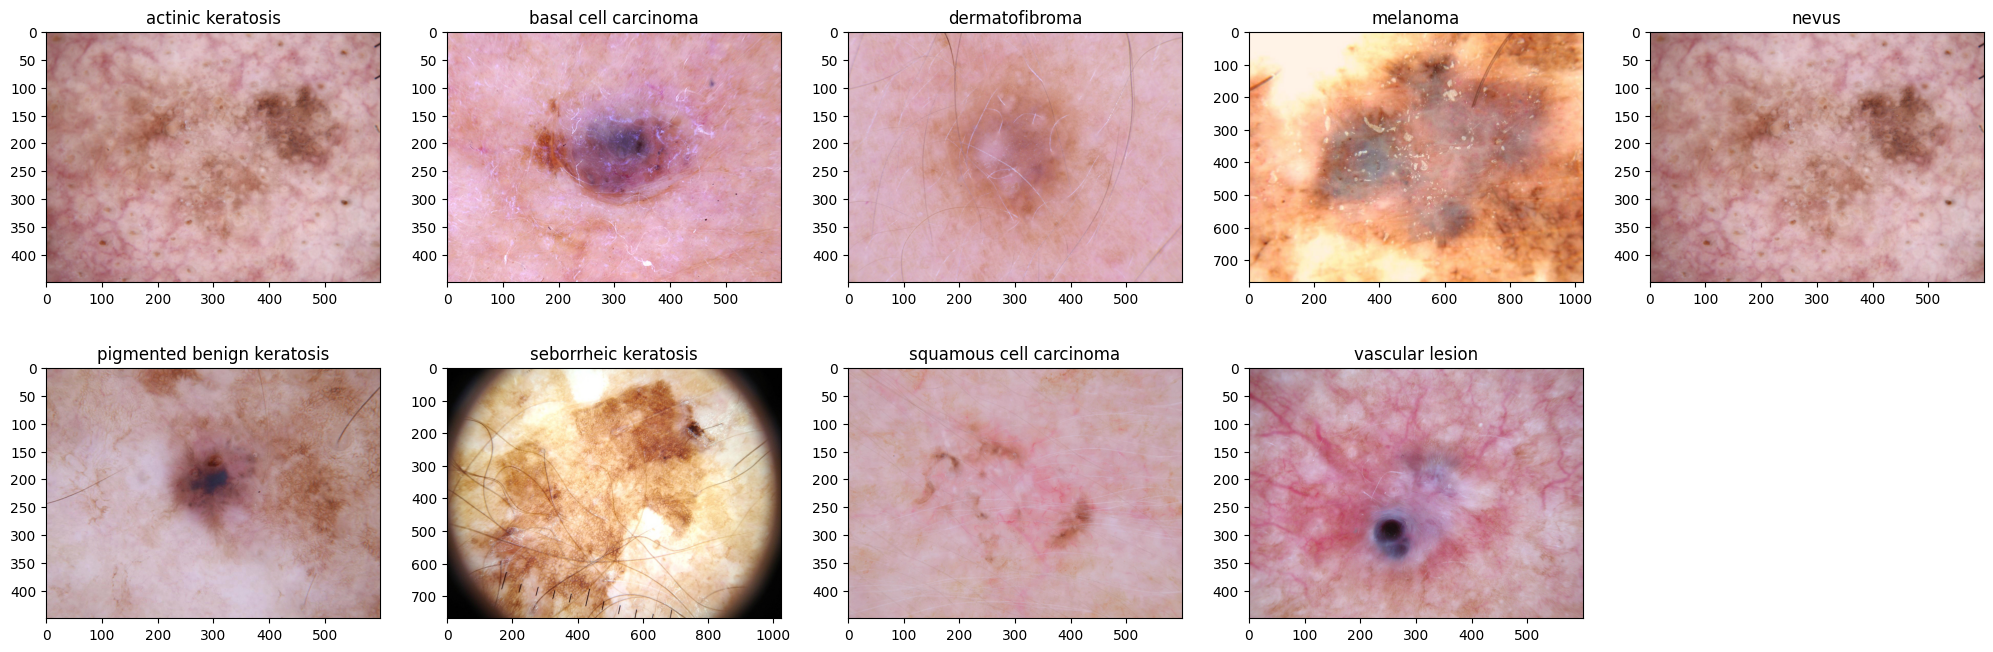

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
# Configure the dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [17]:
# CNN Model
model = Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [18]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 259200)            0

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 28s 118ms/step - loss: 2.8799 - accuracy: 0.2640 - val_loss: 1.6124 - val_accuracy: 0.4094
Epoch 2/20
56/56 [==============================] - 4s 67ms/step - loss: 1.6298 - accuracy: 0.4096 - val_loss: 1.5299 - val_accuracy: 0.5145
Epoch 3/20
56/56 [==============================] - 4s 69ms/step - loss: 1.3795 - accuracy: 0.5073 - val_loss: 1.4712 - val_accuracy: 0.4676
Epoch 4/20
56/56 [==============================] - 4s 67ms/step - loss: 1.2685 - accuracy: 0.5575 - val_loss: 1.3912 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 4s 66ms/step - loss: 1.1494 - accuracy: 0.5982 - val_loss: 1.4629 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 4s 70ms/step - loss: 0.9908 - accuracy: 0.6462 - val_loss: 1.7034 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 4s 67ms/step - loss: 0.8912 - accuracy: 0.6858 - val_loss: 1.4014 - val_accuracy: 0.5190
Epoch 8/20


### Visualizing training results

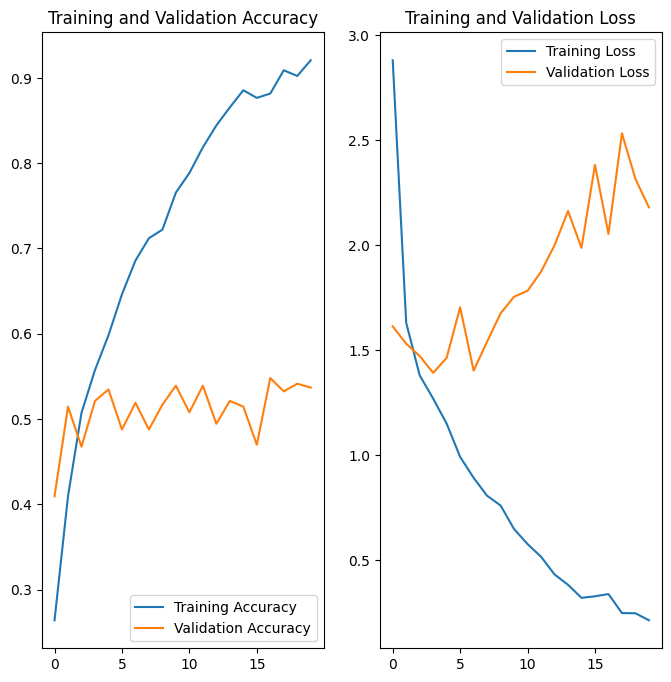

In [21]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

Findings :


1.   As the training accuracy increases linearly over time, where as the validation accuracy stall at 51% accuracy in training process.
2.   As the training loss dereases with epochs the validation loss increases.

1.   The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved around **51% accuracy** on the validation set.
2.   The difference in accuracy between training and validation accuracy is **noticeable** which is a sign of overfitting.

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting
Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

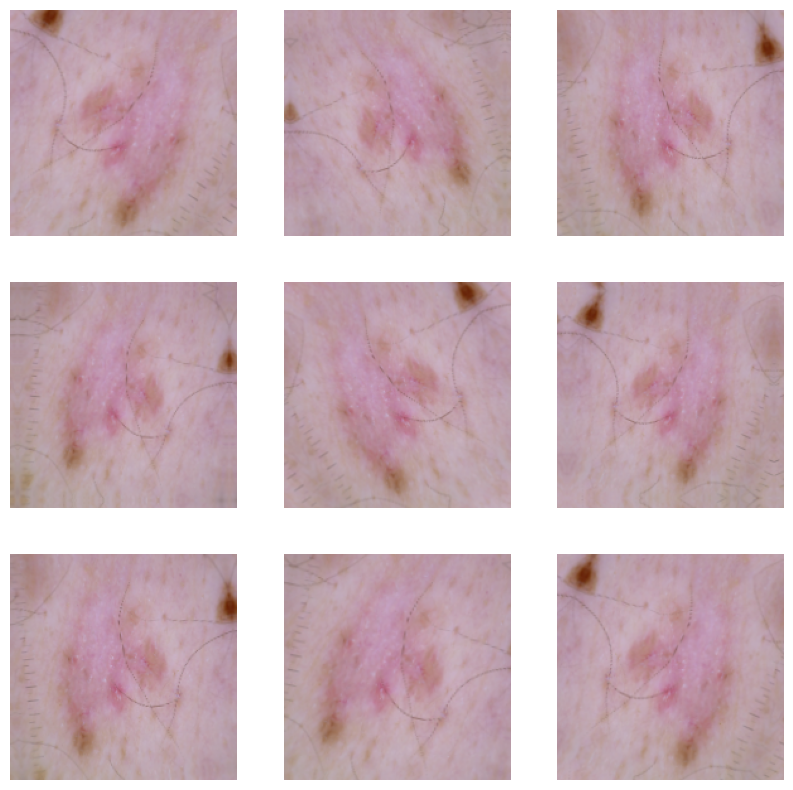

In [23]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model
*   Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
*   Choosing an appropriate optimiser and loss function for model training
*   Training the model for ~20 epochs.
*   Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.


In [24]:
# CNN Model
model = Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

### Compiling the model

In [25]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 6s 72ms/step - loss: 2.7669 - accuracy: 0.2316 - val_loss: 2.4512 - val_accuracy: 0.2573
Epoch 2/20
56/56 [==============================] - 4s 73ms/step - loss: 1.8907 - accuracy: 0.2891 - val_loss: 1.5990 - val_accuracy: 0.4676
Epoch 3/20
56/56 [==============================] - 4s 69ms/step - loss: 1.6069 - accuracy: 0.4291 - val_loss: 1.4953 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 4s 69ms/step - loss: 1.4831 - accuracy: 0.4916 - val_loss: 1.4982 - val_accuracy: 0.4653
Epoch 5/20
56/56 [==============================] - 4s 72ms/step - loss: 1.4435 - accuracy: 0.4927 - val_loss: 1.4518 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 4s 69ms/step - loss: 1.3408 - accuracy: 0.5324 - val_loss: 1.4742 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.3202 - accuracy: 0.5206 - val_loss: 1.5631 - val_accuracy: 0.5235
Epoch 8/20
56

### Visualizing the results

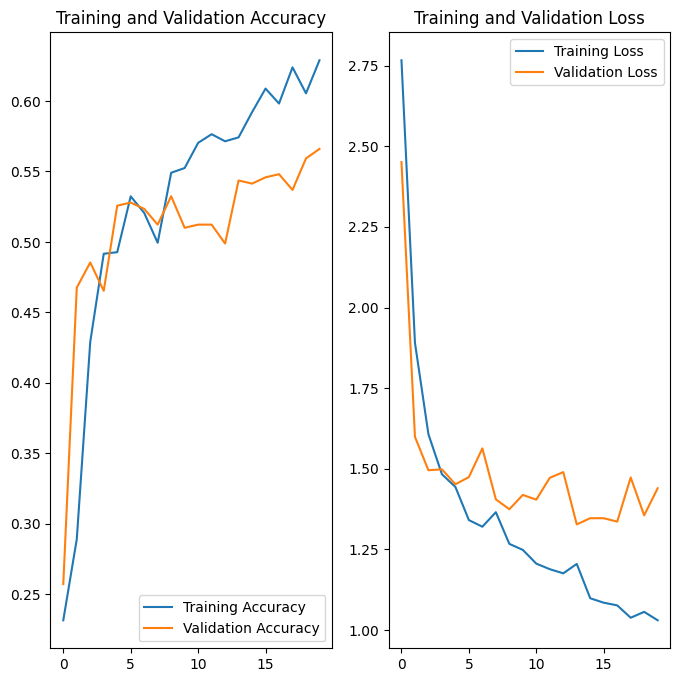

In [27]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

####Findings :
* As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
* As the training loss decreases with epochs the validation loss decreases and stalls.
* The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around **55%** accuracy on the validation set.
* The difference in accuracy between training and validation accuracy is still **slightly noticeable** which is a sign of overfitting.

### Model Building & training on the augmented data with dropout

In [28]:
# CNN Model
model = Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [29]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [30]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 110ms/step - loss: 3.7849 - accuracy: 0.1763 - val_loss: 2.0727 - val_accuracy: 0.1521
Epoch 2/20
56/56 [==============================] - 6s 108ms/step - loss: 1.9851 - accuracy: 0.2450 - val_loss: 1.8611 - val_accuracy: 0.3333
Epoch 3/20
56/56 [==============================] - 6s 108ms/step - loss: 1.7557 - accuracy: 0.3834 - val_loss: 1.6148 - val_accuracy: 0.4273
Epoch 4/20
56/56 [==============================] - 6s 110ms/step - loss: 1.5481 - accuracy: 0.4643 - val_loss: 1.4958 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 6s 109ms/step - loss: 1.4908 - accuracy: 0.4821 - val_loss: 1.4160 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 6s 109ms/step - loss: 1.4099 - accuracy: 0.5123 - val_loss: 1.4601 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 6s 109ms/step - loss: 1.4230 - accuracy: 0.4944 - val_loss: 1.4684 - val_accuracy: 0.5257
Epoch 

Findings :
* As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.
* **As the training loss decreases with epochs the validation loss decreases** 
* The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around **55%** accuracy on the validation set.
* The difference in accuracy between training and validation accuracy is **very less**.

**We can clearly see that the overfitting of the model has redused significantly when compared the earlier models**

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [31]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


#### Findings: 
#### - Which class has the least number of samples?
***seborrheic keratosis with 77 samples***
#### - Which classes dominate the data in terms proportionate number of samples?
***pigmented benign keratosis with 462 samples***


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC0AA642130>: 100%|██████████| 500/500 [00:21<00:00, 23.10 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC0AA6077C0>: 100%|██████████| 500/500 [00:23<00:00, 21.63 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC0AA5F82E0>: 100%|██████████| 500/500 [00:23<00:00, 21.43 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=961x649 at 0x7FC12C4144C0>: 100%|██████████| 500/500 [01:45<00:00,  4.74 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=960x645 at 0x7FC12C3767F0>: 100%|██████████| 500/500 [01:31<00:00,  5.45 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC0AA5E0A00>: 100%|██████████| 500/500 [00:18<00:00, 26.44 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC12C4061F0>: 100%|██████████| 500/500 [00:45<00:00, 11.04 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC12C57DB80>: 100%|██████████| 500/500 [00:19<00:00, 25.05 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC12C5FE4C0>: 100%|██████████| 500/500 [00:17<00:00, 27.81 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000455.jpg_29970acd-274b-4361-9ff0-5808469ad7cd.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000066.jpg_d262e624-a448-4d96-a8f7-2ca694130721.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000397.jpg_3d4d3030-89ed-42cc-8d59-58c6cc8eede4.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000370.jpg_c1c6c2d0-ec75-4476-b8a9-303de161c94d.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000327.jpg_28eaab4f-6864-4034-a4ac-2e3154fc82fa.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027334.jpg_7e8d94b1-6664-4cd6-afeb-39ba7156eba5.jpg'

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [37]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [38]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [39]:
new_df['Label'].value_counts()

nevus                         500
basal cell carcinoma          500
actinic keratosis             500
dermatofibroma                500
squamous cell carcinoma       500
melanoma                      500
vascular lesion               500
seborrheic keratosis          500
pigmented benign keratosis    500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
# CNN Model
model = Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

#### Compile your model (Choose optimizer and loss function appropriately)

In [44]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

#### Train your model

In [47]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 31s 178ms/step - loss: 1.2154 - accuracy: 0.5467 - val_loss: 1.3017 - val_accuracy: 0.5189
Epoch 2/30
169/169 [==============================] - 31s 181ms/step - loss: 1.1706 - accuracy: 0.5582 - val_loss: 1.1742 - val_accuracy: 0.5568
Epoch 3/30
169/169 [==============================] - 32s 183ms/step - loss: 1.0987 - accuracy: 0.5792 - val_loss: 1.1325 - val_accuracy: 0.5813
Epoch 4/30
169/169 [==============================] - 37s 213ms/step - loss: 1.0404 - accuracy: 0.6081 - val_loss: 1.1017 - val_accuracy: 0.5932
Epoch 5/30
169/169 [==============================] - 31s 177ms/step - loss: 1.0248 - accuracy: 0.6209 - val_loss: 1.0354 - val_accuracy: 0.6214
Epoch 6/30
169/169 [==============================] - 31s 178ms/step - loss: 0.9479 - accuracy: 0.6439 - val_loss: 0.9668 - val_accuracy: 0.6303
Epoch 7/30
169/169 [==============================] - 33s 187ms/step - loss: 0.9276 - accuracy: 0.6588 - val_loss: 0.9880 - val_ac

####  Visualize the model results

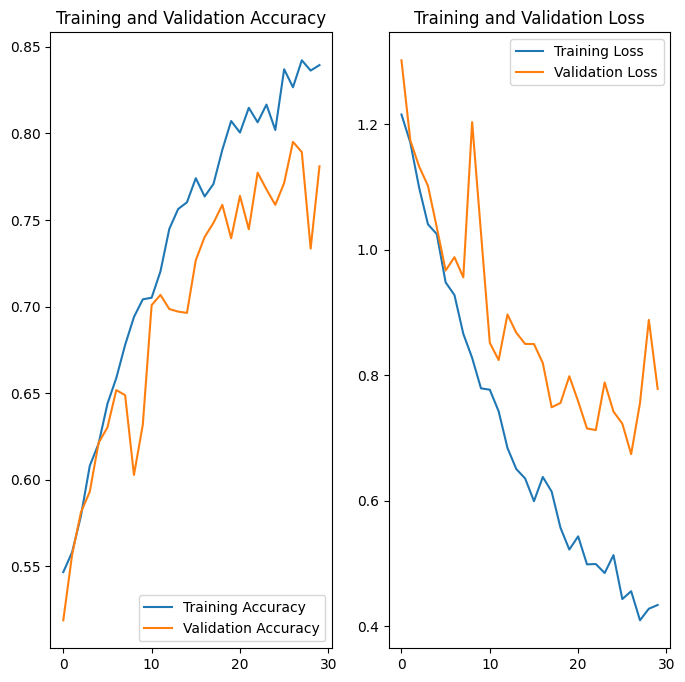

In [48]:
# Visualizing model results
plot_cnn_metrics(history,epochs)

**Findings** :
* As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.
* As the training loss decreases with epochs the validation loss also decreases.
* The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around **78%** accuracy on the validation set.
* The difference in accuracy between training and validation accuracy is **very less**


<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <p>Class rebalancing not only got rid of overfitting it also improved the accuracy from 55% to 78%.</p>
    </span>
</div>    